## Imports

In [1]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [3]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.6002, 0.4961, 0.3605], std=[0.2681, 0.2808, 0.2984]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [4]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Display All Loss & Accuracy Curves on a Single Plot

In [6]:
# Load the VGG16 model.
PATH = "../saved_models/ingredients/vgg16/vgg16.dat"
model = torch.load(PATH)

results = torch.load('../saved_models/ingredients/vgg16/vgg16-results.pt')
train_results, val_results = results['train'], results['val']
LOSS_VGG, ACC_VGG, LOSS_V_VGG, ACC_V_VGG = (train_results['loss_history'], train_results['accuracy_history'], 
                                            val_results['loss_history'], val_results['accuracy_history'])

print(len(LOSS_VGG))

50


In [7]:
# Load the Res18 model.

PATH = "../saved_models/ingredients/res18/res18.dat"
model = torch.load(PATH)

results = torch.load('../saved_models/ingredients/res18/res18-results.pt')
train_results, val_results = results['train'], results['val']
LOSS_RES, ACC_RES, LOSS_V_RES, ACC_V_RES = (train_results['loss_history'], train_results['accuracy_history'], 
                                            val_results['loss_history'], val_results['accuracy_history'])

print(len(LOSS_RES))

20


In [8]:
# Load the ResNext model.
PATH = "../saved_models/ingredients/resnext/resnext.dat"
model = torch.load(PATH)

results1 = torch.load('../saved_models/ingredients/resnext/resnext-results-1.pt')
results2 = torch.load('../saved_models/ingredients/resnext/resnext-results-2.pt')

train_results1, val_results1 = results1['train'], results1['val']
train_results2, val_results2 = results2['train'], results2['val']

LOSS1, ACC1, LOSS_V1, ACC_V1 = (train_results1['loss_history'], train_results1['accuracy_history'], 
                                val_results1['loss_history'], val_results1['accuracy_history'])
LOSS2, ACC2, LOSS_V2, ACC_V2 = (train_results2['loss_history'], train_results2['accuracy_history'], 
                                val_results2['loss_history'], val_results2['accuracy_history'])

LOSS_RESNEXT = LOSS1 + LOSS2
ACC_RESNEXT = ACC1 + ACC2
LOSS_V_RESNEXT = LOSS_V1 + LOSS_V2
ACC_V_RESNEXT = ACC_V1 + ACC_V2
print(len(LOSS_RESNEXT))

10


In [9]:
# Load the MultiTask model.

class MultiModal(nn.Module):
    def __init__(self, resnet):
        super(MultiModal, self).__init__()
        self.resnet = resnet
        self.relu = nn.ReLU()
        self.food = nn.Linear(1000, 172) # nn.Sequential(nn.Linear(1000, 4096), nn.ReLU(), nn.Dropout(), nn.Linear(4096, 172))
        self.ingredients = nn.Sequential(nn.Linear(1000, 353), nn.Sigmoid()) # nn.Sequential(nn.Linear(1000, 1024), nn.ReLU(), nn.Dropout(), nn.Linear(1024, 353), nn.Sigmoid())

    def forward(self, x):
        a = self.resnet(x)
        b = self.relu(a)
        food_output = self.food(b)
        ingredient_output = self.ingredients(b)
        return (food_output, ingredient_output)

PATH = "../saved_models/ingredients/multi_modal/multi_modal.dat"
model = torch.load(PATH)

results = torch.load('../saved_models/ingredients/multi_modal/multi_modal-results.pt')
train_results, val_results = results['train'], results['val']
LOSS_MM, ACC_MM, LOSS_V_MM, ACC_V_MM = (train_results['loss_history'], train_results['ingre_accuracy_history'], 
                                            val_results['loss_history'], val_results['ingre_accuracy_history'])

print(len(LOSS_MM))

10


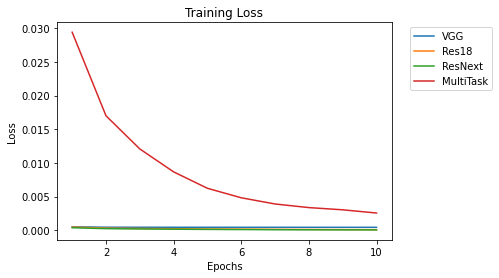

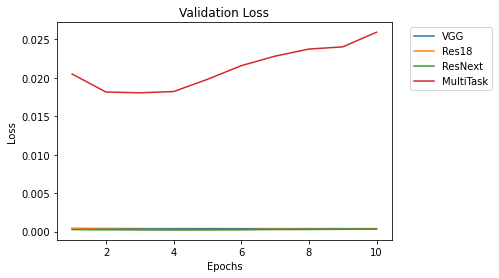

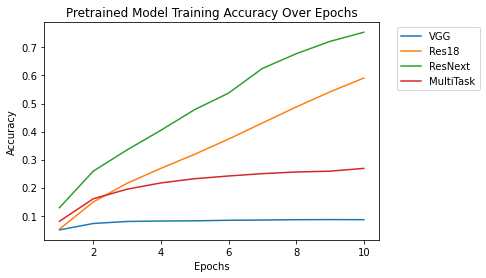

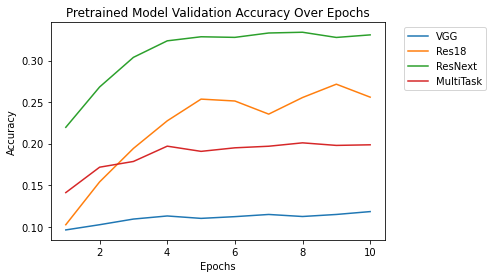

Final VGG16 Training Accuracy:  tensor(0.0909, device='cuda:0')
Final VGG16 Validation Accuracy:  tensor(0.1156, device='cuda:0')
Final Res18 Training Accuracy:  0.8300918708661894
Final Res18 Validation Accuracy:  0.2565359477124183
Final ResNext Training Accuracy:  0.7541735405851281
Final ResNext Validation Accuracy:  0.3309731299927378
Final MultiTask Training Accuracy:  0.2687260674123292
Final MultiTask Validation Accuracy:  0.19862018881626725


In [10]:
# Plot deep models on a SINGLE plot

epochs = 10

plt.figure()
E = np.arange(epochs)+1

plt.plot(E,LOSS_VGG[:epochs],label='VGG')
plt.plot(E,LOSS_RES[:epochs],label='Res18')
plt.plot(E,LOSS_RESNEXT[:epochs],label='ResNext')
plt.plot(E,LOSS_MM[:epochs],label='MultiTask')


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure()

plt.plot(E,LOSS_V_VGG[:epochs],label='VGG')
plt.plot(E,LOSS_V_RES[:epochs],label='Res18')
plt.plot(E,LOSS_V_RESNEXT[:epochs],label='ResNext')
plt.plot(E,LOSS_V_MM[:epochs],label='MultiTask')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure()

plt.plot(E,ACC_VGG[:epochs],label='VGG')
plt.plot(E,ACC_RES[:epochs],label='Res18')
plt.plot(E,ACC_RESNEXT[:epochs],label='ResNext')
plt.plot(E,ACC_MM[:epochs],label='MultiTask')


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pretrained Model Training Accuracy Over Epochs")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure()

plt.plot(E,ACC_V_VGG[:epochs],label='VGG')
plt.plot(E,ACC_V_RES[:epochs],label='Res18')
plt.plot(E,ACC_V_RESNEXT[:epochs],label='ResNext')
plt.plot(E,ACC_V_MM[:epochs],label='MultiTask')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pretrained Model Validation Accuracy Over Epochs")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

print("Final VGG16 Training Accuracy: ", ACC_VGG[-1])
print("Final VGG16 Validation Accuracy: ", ACC_V_VGG[-1])
print("Final Res18 Training Accuracy: ", ACC_RES[-1])
print("Final Res18 Validation Accuracy: ", ACC_V_RES[-1])
print("Final ResNext Training Accuracy: ", ACC_RESNEXT[-1])
print("Final ResNext Validation Accuracy: ", ACC_V_RESNEXT[-1])
print("Final MultiTask Training Accuracy: ", ACC_MM[-1])
print("Final MultiTask Validation Accuracy: ", ACC_V_MM[-1])